Prueba de jupyter notebook
Ejemplos de uso de networkx para futuras referrencias

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
# For color mapping
import matplotlib.colors as colors
import matplotlib.cm as cmx
from networkx.algorithms import community

from mymod import mymodularity
from tabusearch import tabu_modularity_optimization

Obtenemos datos de los nodos y enlaces de los csv:

In [20]:
nodes_path = r'C:\Users\proal\Documents\UC3M\2021-2022\2\TFG\algoritmo1\datos\Nodes_t1.csv'
edges_path = r'C:\Users\proal\Documents\UC3M\2021-2022\2\TFG\algoritmo1\datos\Edges_t1.csv'
df_nodes = pd.read_csv(nodes_path, sep = ';',encoding='unicode_escape')
df_edges = pd.read_csv(edges_path, sep = ';',encoding='unicode_escape')

Creamos Grafo direccionado con pesos múltiple:

In [21]:
MDG = nx.MultiDiGraph()
MDG.add_nodes_from(df_nodes['Nodes'])

tuples_from_to = []
for i in range(len(df_edges)):
    #tuples_from_to.append((df_edges['from'][i],df_edges['to'][i],{"weight":df_edges['weight'][i]}))
    tuples_from_to.append((df_edges['from'][i],df_edges['to'][i],df_edges['weight'][i]))

MDG.add_weighted_edges_from(tuples_from_to)
# Para obtener los todos los pesos:
#print([element[2]['weight'] for element in list(MDG.edges(data=True))])

Dibujamos grafo de distintas formas
Primero coloreando los enlaces positivos y negativos

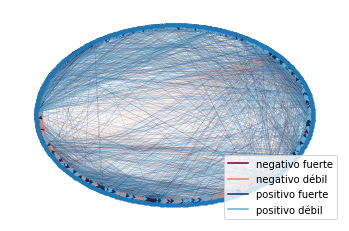

In [22]:
#Creamos leyenda en función de las relaciones en
cNorm = colors.Normalize(vmin = df_edges['weight'].min(), vmax = df_edges['weight'].max())
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = plt.cm.RdBu)
ColorLegend = {'negativo fuerte': -2, 
           'negativo débil': -1, 
           'positivo fuerte': 2, 
           'positivo débil': 1}

f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[0],color=scalarMap.to_rgba(ColorLegend[label]),label=label)

plt.legend(loc = 'lower right')
nx.draw_shell(MDG,node_size=10,width = 0.1,vmin = df_edges['weight'].min(),vmax=df_edges['weight'].max(),edge_color=df_edges['weight'],edge_cmap=plt.cm.RdBu,ax=ax)
plt.show()

In [23]:
# nx.draw_random(MDG,node_size=10,width = 0.1,edge_color=df_edges['weight'],edge_cmap=plt.cm.RdBu)

# plt.show()

In [24]:
# nx.draw_spring(MDG,node_size=10,width = 0.1,edge_color=df_edges['weight'],edge_cmap=plt.cm.RdBu)
# print(MDG)
# plt.show()

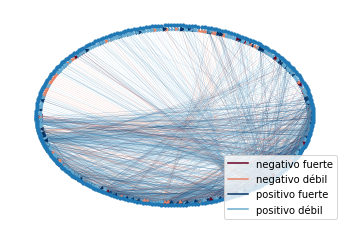

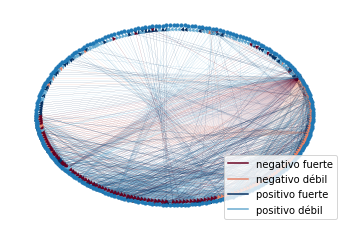

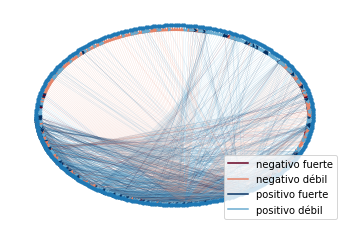

In [25]:
c = list(community.modularity_max.greedy_modularity_communities(MDG))


for k in c:
    mdg_iter = nx.MultiDiGraph()
    mdg_iter.add_nodes_from(k)
    tuples_from_to = []
    for i in k:
        # Encontramos filas de la lista de pesos que tenga de 'from' el nodo 'i' de esta comunidad
        rows_found = df_edges.loc[df_edges['from'] == i]
        list_from = rows_found['from'].tolist()
        list_to = rows_found['to'].tolist()
        list_weight = rows_found['weight'].tolist()

        for j in range(len(rows_found)):
            tuples_from_to.append((list_from[j], list_to[j], list_weight[j]))

    mdg_iter.add_weighted_edges_from(tuples_from_to)

    resulting_weights = list(map(lambda x: x[2], tuples_from_to))

    #Creamos leyenda en función de las relaciones en
    cNorm = colors.Normalize(vmin = min(resulting_weights), vmax = max(resulting_weights))
    scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = plt.cm.RdBu)
    ColorLegend = {'negativo fuerte': -2, 
               'negativo débil': -1, 
               'positivo fuerte': 2, 
               'positivo débil': 1}

    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)
    for label in ColorLegend:
        ax.plot([0],[0],color=scalarMap.to_rgba(ColorLegend[label]),label=label)

    plt.legend(loc = 'lower right')
    nx.draw_shell(mdg_iter,node_size=10,width = 0.1,vmin = min(resulting_weights), vmax = max(resulting_weights), edge_color = resulting_weights ,edge_cmap=plt.cm.RdBu,ax=ax)
    plt.show()

Si calculamos la modularidad de esta partición, con la función que existe en networkx:

In [26]:
print(community.quality.modularity(MDG,c,weight='weight',resolution=1))

0.5432851126031202


En cambio, si calculamos la modularidad con nuestra función, que tiene en cuenta los pesos negativos:

In [28]:
print(mymodularity(MDG,c))
comunidades_optimizadas = tabu_modularity_optimization(MDG,c)
print(mymodularity(MDG,comunidades_optimizadas))

0.25408757068193605
originalmente [frozenset({512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 340, 371, 388, 405, 407, 411, 414, 415, 427, 435, 436, 439, 441, 446, 447, 456, 462, 463, 469, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511}), frozenset({191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 2

KeyboardInterrupt: 